# 08.01 Principal Component Analysis

PCA is an unsupervised algorithm which reduces the feature space.
The algorithm builds a projection of the feature space into a space
with a smaller number of dimensions.
The new feature space is not necessarily meaningful in terms of the original features,
because the projection plane (or hyperplane) may cross the features diagonally.

Let us start with the idea of projections.
Data points are no more than multidimensional arrays,
and in Linear Algebra multiplication between arrays of
different dimensions performs a projection between the dimensions.
We import a handful of things and build a simple example of a function
in $3$ dimensions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
from mpl_toolkits import mplot3d

We will have two classes: red and blue.
These data will reside in three dimensions,
and we could call the class itself a fourth dimension.
The classes have no meaning in this case but they
allow us to visualize which side of the data we are looking at.

The *meshgrid* produces all combinations between $x$ and $y$ features,
and we build a almost-dependent $z$ feature.
The $z$ feature will be a function of $x$ and $y$ but
with some noise added in.
We have.

$$
z = f(x, y) \approx x^2 + y
$$

And for the classes, we define them in terms of $x$ and $z$

$$
red = z > 20, x < 10 \approx \sqrt{20 - y} < x < 10
$$

The full set look as follows.

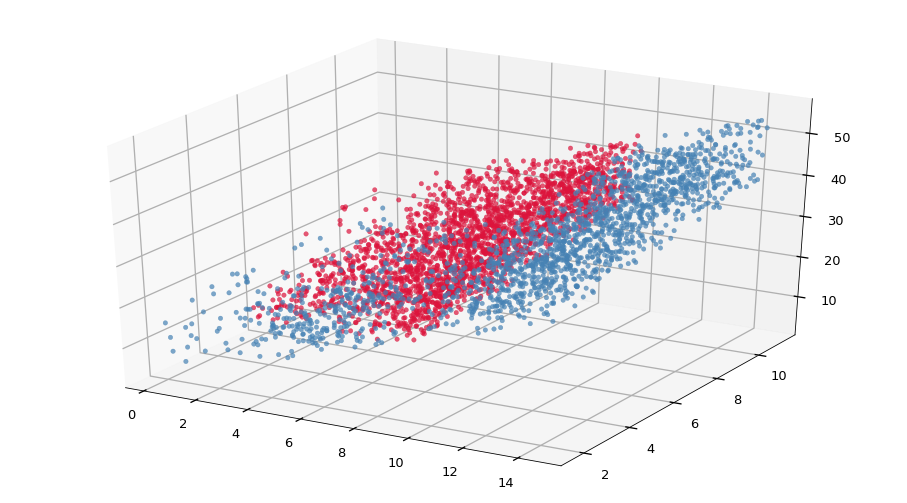

In [2]:
points = 64
x = np.linspace(0, 10, points) + 7*np.random.rand(points)
y = np.linspace(0, 10, points) + 3*np.random.rand(points)
gx, gy = np.meshgrid(x, y)
z = 2*gx + gy + 15*np.random.rand(points, points)
red = (z > 20) & (x < 10)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gx[red], gy[red], z[red], c='crimson', alpha=0.7)
ax.scatter(gx[~red], gy[~red], z[~red], c='steelblue', alpha=0.7);

The combination of the arrays is three dimensional
but a s we saw before we can *melt* the three dimensional
representation into a two dimensional one.
We build a matrix (a two dimensional array or a data frame)
representing each feature as a column.
This is the most common data representation we see.

In [3]:
df = pd.DataFrame({'x': gx.reshape(-1), 'y': gy.reshape(-1), 'z': z.reshape(-1)})
df

,x,y,z
0,0.325168,2.718422,12.430248
1,3.928762,2.718422,20.879095
2,4.412740,2.718422,12.547498
3,6.080664,2.718422,15.690980
4,2.462841,2.718422,18.423135
...,...,...,...
4091,13.801802,10.036509,43.700409
4092,14.407722,10.036509,41.457652
4093,12.937877,10.036509,42.865677
4094,12.218582,10.036509,45.049026


Now that we have all our data as a matrix we can do linear algebra on top of it.
Matrix multiplication is only possible if the left operand has the same number
of columns as the right operand has of rows.

$$
X_{n \times m} T_{p \times q}
$$

Is only possible if $m = p$.
In other words $A_{2 \times 3}$ can multiply $B_{3 \times 5}$
but $B_{3 \times 5}$ cannot multiply $A_{2 \times 3}$.
Yes, you did read that right, matrix multiplication is not commutative.
$A_{2 \times 3}$ must be on the left hand side of the multiplication
and $B_{3 \times 5}$ must be on the right hand side.
And the result of the multiplication will have
$n$ rows and $q$ columns.

$$
X_{n \times m} T_{p \times q} = M_{n \times q}
$$

Our piece of data is a matrix which we will call $X_{4096 \times 3}$.
We can (left) multiply a matrix $T_{n \times 4096}$ by our matrix,
or we can (right) multiply our matrix by a matrix $T_{3 \times m}$.
The terms left multiplication and right multiplication are from linear
algebra and mean the use of the other matrix by which we multiply
on the left or right of the matrix we want to multiply.

Since $T_{3 \times m}$ is a lot easier to build than $T_{n \times 4096}$,
we will build the former and left multiply our data by it.
For simplicity we will use a square matrix $T_{3 \times 3}$.
We use the letter $T$ for this matrix to mean *transform*,
and we write `TR` in the code.
Note that `@` is Python's own matrix multiplication operator.

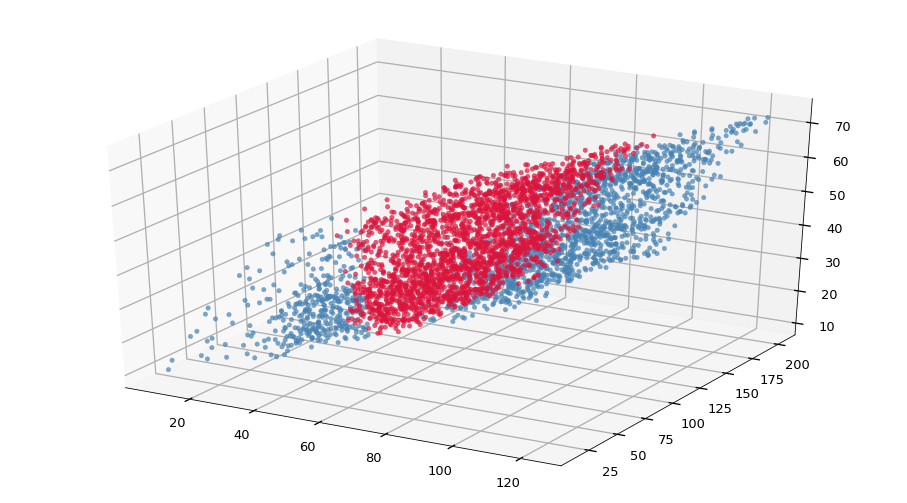

In [4]:
TR = np.array([
    [1, 2, -1],
    [0, 1,  3],
    [2, 3,  1],
])
M = df.values @ TR
mx, my, mz = M[:, 0], M[:, 1], M[:, 2]

mred = red.reshape(-1)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mx[mred], my[mred], mz[mred], c='crimson', alpha=0.7)
ax.scatter(mx[~mred], my[~mred], mz[~mred], c='steelblue', alpha=0.7);

Since we multiplied across the features of our $X_{4096 \times 3}$
we kept the number of samples ($4096$) and since the matrix
$T_{3 \times 3}$ is square we kept the number of features (dimensions).
The end results is that the values in side $T_{3 \times 3}$ move,
rotate or stretch our data;
but the end result is still $4096$ points in three dimensional space.

The multiplication we are interested in though is to reduce the number
of the dimensions.
Since our $X_{4096 \times 3}$ has $3$ columns then our $MT{3 \times m}$
must have $3$ rows in order for the multiplication to be possible (defined).
But the number of columns of $T_{3 \times m}$ is not required to be $3$.

If we right multiply our data, $X_{4096 \times 3}$ by a matrix
$T_{3 \times 2}$ the result will be some matrix $M_{4096 \times 2}$.
This $M_{4096 \times 2}$ is a representation of $4096$ points in
$2$ dimensions, hence we projected our our data points
from $3$ dimensions into $2$ dimensions.

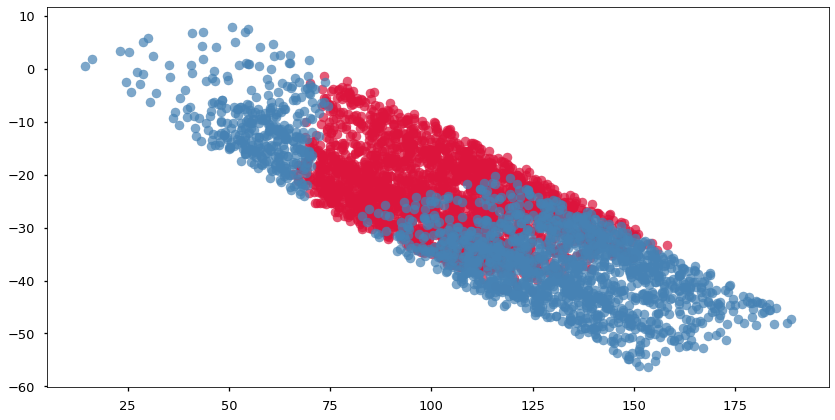

In [5]:
TR = np.array([
    [1, -1],
    [1,  2],
    [3, -1],
])
M = df.values @ TR
mx, my = M[:, 0], M[:, 1]

mred = red.reshape(-1)
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(mx[mred], my[mred], c='crimson', alpha=0.7)
ax.scatter(mx[~mred], my[~mred], c='steelblue', alpha=0.7);

We now know know how to project data between dimensions.
All we need to do is to create a transform matrix ($T$)
with the same number of rows as the number of columns
(dimensions, features) in our data and multiply them.
In other words, we know how to perform a rather simple
dimensionality reduction.

The problem is that the numbers inside the matrix $T$
shape the projection in different ways.
The numbers squeeze, rotate, and move the data around.
Moreover, before we had $4096 \cdot 3 = 12288$ values
representing our data now we have $4096 \cdot 2 = 8192$ values.
Therefore we lost some information about our data
in the process of the projection.
If we want to minimize the amount of information we lose
during the projection we must have a way of selecting the
best numbers for the values inside $T$.
Enters Principal Component Analysis (PCA).

PCA find the best projection that **minimizes the loss of variance**
within the data we project.
For the time being let us argue that PCA has a way of finding
the best possible transformation matrix to minimize the
loss in variance across the data.
Another detail of the transformation matrix is that the
rotation operation that the transformation performs
is always around the origin.
Hence PCA will move the data so that the mean in every
dimension is zero, i.e. that the data is centered at the origin.
This way the rotations happen around the middle of the data itself.

When used from `sklearn`,
PCA behaves just as any other `sklearn` model.
PCA expects to be given the number of components we project onto,
this is a hyperparameter of the PCA algorithm.
We are rather confident that we can take the data above and
live with its variance in two dimensions only,
therefore we will use $2$ components.

Since the $z$ feature is almost fully dependent on the values of $x$ and $y$,
the variance in $z$ can be explained by the variance in $x$ and $y$.
We expect that PCA will figure that out and flatten out the $z$ feature.
PCA is a transformation hence we use the `transform` method
(or more exactly `fit_transform` here) to project the data.
The result is still the same data but in less dimensions.
This can be visualized or passed on to other models.

array([[-0.30114245, -0.48460744],
       [-0.11265113,  0.87328861],
       [-0.94690176,  0.05022583]])

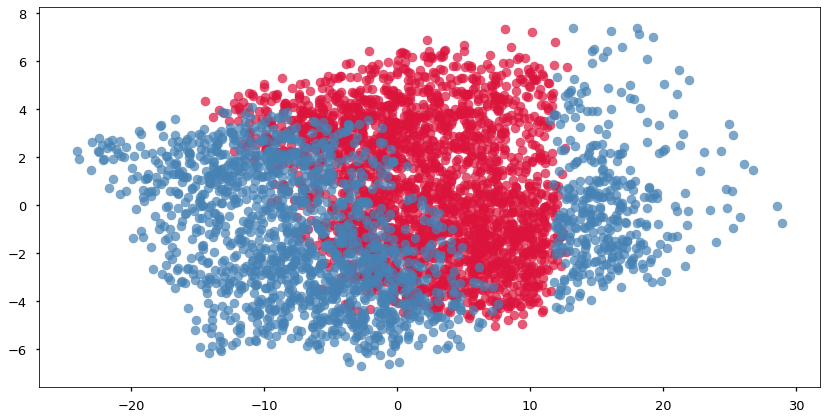

In [6]:
from sklearn.decomposition import PCA

X = np.c_[gx.reshape(-1), gy.reshape(-1), z.reshape(-1)]
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
red_new = red.reshape(-1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(X_new[red_new, 0], X_new[red_new, 1], color='crimson', alpha=0.7)
ax.scatter(X_new[~red_new, 0], X_new[~red_new, 1], color='steelblue', alpha=0.7)
pca.components_.T

And since we know that the projection is just a matrix multiplication
we can perform the PCA by hand ourselves.
We just need to move the data so its mean is zero
(subtract the mean from the data in every dimensions)
and perform the matrix multiplication with the matrix
found by PCA during the `fit` procedure.
That matrix lives at the `components_` attribute.

We need to use the transpose if the matrix PCA finds
for historical reasons.
Reason we will see shortly.

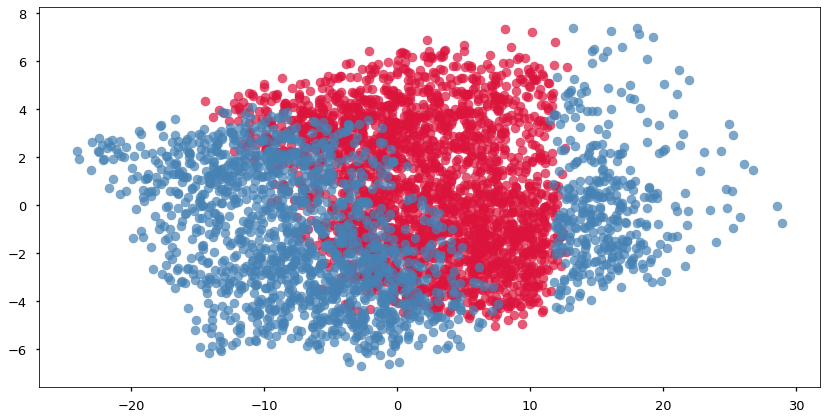

In [7]:
df_or = df - df.mean()
M = df_or.values @ pca.components_.T
mx, my = M[:, 0], M[:, 1]

mred = red.reshape(-1)
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(mx[mred], my[mred], c='crimson', alpha=0.7)
ax.scatter(mx[~mred], my[~mred], c='steelblue', alpha=0.7);

The only secret remaining is how PCA actually find this optimal transform matrix.
The algorithm works by decomposing the space into eigenvectors and eigenvalues.
Then it reorders the eigenvectors in order of how much variance they explain,
i.e. in order of the eigenvalues.

It is a common misconception that PCA searches for the eigenvectors and
eigenvalues within the data.
Eigenvectors and eigenvalues are only defined for square matrices,
and PCA perform the following matrix multiplication.

$$
X_{4096 \times 3}^T X_{4096 \times 3}
$$

Which results in a matrix of $3$ rows and $3$ columns, a square matrix.
Remember that $X^T$ is the transpose of the matrix $X$.
This resulting matrix is also symmetric across its main diagonal,
which gives it the property that all its eigenvectors are
perpendicular to each other.
A perfect selection of vectors to select from as new dimensions.
New dimensions shall be perpendicular to each other in order
to not deform the data when projecting.

And the reason that PCA minimizes the loss in variance is because
the matrix result from $X^T X$ is proportional to the covariance
matrix of $X$.
This is often written.

$$
X_{4096 \times 3}^T X_{4096 \times 3} \propto cov(X)
$$

The symbol $\propto$ means proportional.
The covariance matrix of $X$ is the covariance across
all combinations of columns of $X$.
And the eigenvectors of the covariance matrix
point in the direction of maximum variance,
whilst within the boundaries of being perpendicular to each other.
Each eigenvector then points towards the maximum variance
discounting all eigenvectors before it.
A square and symmetric covariance matrix of $n$ rows and columns
has $n$ real eigenvectors,
which ordered in decreasing order of eigenvalues are the projections,
are the projections which minimize the loss in variance.

Finding the eigenvectors and the eigenvalues from $X^TX$ is a quite
complex task, with two iterative algorithms: one to find the
eigenvalues and another to find the eigenvectors from the eigenvalues.
But the task is made much easier by the fact that computing $X^TX$ is cheap,
whilst computing the covariance matrix for $X$ can be very expensive.
And since both are proportional to each other their eigenvectors
point in the same directions.

![David Hilbert](ul-hilbert.svg)

<div style="text-align:right;"><sup>ul-hilbert.svg</sup></div>

<div style="border: 0.3em double teal; border-radius: 0.5em; padding: 0.5em">
    David Hilbert was perhaps the creator of mathematical logic as a discipline.
    His work, although conflicting with Gödel's, led to the development of axiomatic mathematics.
    It is due to both Gödel and Hilbert that mathematicians today start they statements with
    "If we assume that...".
    Hilbert was also the one to name what we today know and Eigenvalues and Eigenvectors.
    The concepts have been known as far back as early work by Maxwell but the importance
    to Linear Algebra has been seen by Hilbert.
</div>

The eigenvectors exist in the same dimensions as our data.
In our case the data is in $3$ dimensions,
and $X^TX$ is also a matrix of $3$ columns (and $3$ rows).
This allows us to visualize where the eigenvectors lie
in the space of our data
(assuming that we can visualize that space in the first place that is).

The PCA `components_` attribute is not only the transformation matrix
but it is also the set of eigenvectors used for the transformation.
The matrix and the eigenvectors are one and the same.
And since it is common for us to use columns as dimensions,
this is the reason we keep the matrix in `components_`
with the same number of columns as the original data.
And also the reason we needed to use the transpose earlier.
The `explained_variance_ratio_` contains the scaled eigenvalues
so that they all sum to $1$.

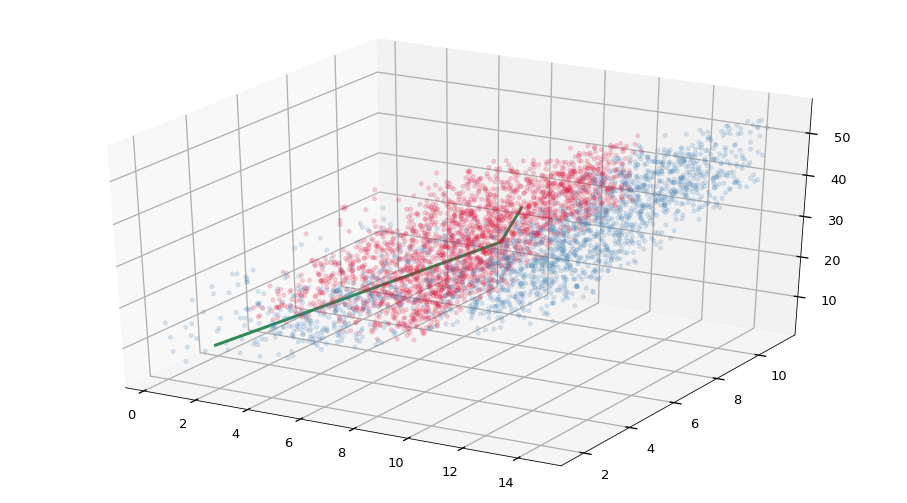

In [8]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gx[red], gy[red], z[red], c='crimson', alpha=0.2)
ax.scatter(gx[~red], gy[~red], z[~red], c='steelblue', alpha=0.2);

M = np.c_[gx.mean(), gy.mean(), z.mean()]
sizes = pca.explained_variance_ratio_ / pca.explained_variance_ratio_.min()
eigen = pca.components_ * sizes[:, np.newaxis]
ax.quiver(M[[0, 0], 0], M[[0, 0], 1], M[[0, 0], 2],
          eigen[:, 0], eigen[:, 1], eigen[:, 2],
          linewidths=3, color='seagreen', length=3, arrow_length_ratio=0);

Since the projection can be done in one way,
in our case from $3$ to $2$ dimensions,
we can perform the inverse projection too.
In order to do that we only need to right multiply
by the transpose of the transformation matrix.
Or, in the case of the PCA implementation by the `components_`
attribute itself since it is already transposed.

This inverse projection allow us to see what information was lost
during the original projection.
We cannot recover the information that was lost because it was thrown away.
In the top graph we see the original data,
whilst in the second we see the data that was projected into $2$
dimensions - with information loss - and then projected back to $3$ dimensions.
In the second graph the data is flat,
most of the variance over the $z$ coordinate has been thrown away.

This inverse transformation is available directly on the PCA model,
under the `inverse_transform` method.

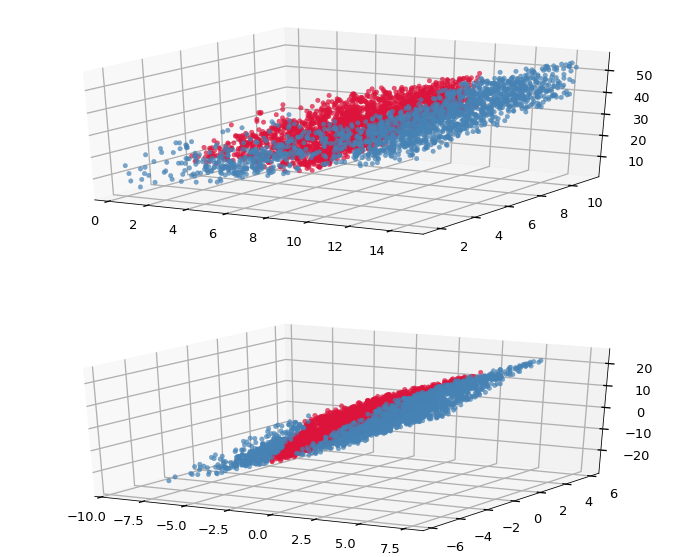

In [9]:
M = X_new @ pca.components_
mx, my, mz = M[:, 0], M[:, 1], M[:, 2]

mred = red.reshape(-1)
fig = plt.figure(figsize=(12, 10))
ax_u = fig.add_subplot(211, projection='3d')
ax_d = fig.add_subplot(212, projection='3d')
ax_u.scatter(gx[red], gy[red], z[red], c='crimson', alpha=0.7)
ax_u.scatter(gx[~red], gy[~red], z[~red], c='steelblue', alpha=0.7);
ax_d.scatter(mx[mred], my[mred], mz[mred], c='crimson', alpha=0.7)
ax_d.scatter(mx[~mred], my[~mred], mz[~mred], c='steelblue', alpha=0.7);
ax_u.view_init(elev=25., azim=-60)
ax_d.view_init(elev=25., azim=-60)

### Linearity of PCA and manifold techniques

PCA is a technique that depends on the linearity of the dimensions it works with.
Relations that are non-linear, such as the letter B we saw earlier,
cannot be captured by PCA.
Covariance and variance are components of correlation,
and hence techniques to identify linear relations after all.

To deal with non-linear relationships manifold techniques were developed.
A manifold is a space that more-or-less look like euclidean space
but it is bent in several ways,
e.g. a bent sheet of paper in three dimensional space.
These techniques are based on maintaining distances between points in the data
instead of maintaining the variance within specific dimensions.
That said, PCA is easy to interpret due to the cumulative variance,
yet it is often difficult to interpret what a manifold technique is doing.
Moreover, there is no definitive measure of whether a manifold technique will
or will not converge for a particular dataset,
and manifold techniques are more sensitive to outliers than PCA.

As a rule of thumb,
it is wise to attempt manifold techniques only after attempting PCA
and understanding the shape of the data.
Some manifold techniques include:

- Multidimensional Scaling (MDS) is the simplest manifold which works by preserving
  (as much as possible) the distances between *all* points in the dataset.

- Locally Linear Embedding (LLE) works like MDS but only preserves distances within
  a defined number of neighbors, this allows to "unroll" certain relationships.

- Isomap is similar to LLE in that it uses a neighbor search but then computes
  eigenvectors over the local groups.

- Spectral Embedding is a stochastic way of building eigenmaps from a graph based
  neighbor search, this makes it similar to LLE.

- t-distributed Stochastic Neighbor Embedding (t-SNE) may reveal structures at
  different scales since it builds several t-distributions (similar to a bell shape)
  within groups of neighbors and then works with these t-distributions instead
  of the actual data points.